# Optimizers and Schedulers: Homework

> Implementing Cosine Annealing and the OneCycle scheduler from scratch

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
plt.style.use("ggplot")

Recall, we want something to situate within this interface

```python
class BaseSchedulerCB(Callback):
    """Base callback class for schedulers"""

    def __init__(self, scheduler_f, **kwargs):
        self.scheduler_f = scheduler_f
        self.sched_kwargs = kwargs
        self.sched = None

    def before_fit(self, learn):
        self.sched = self.scheduler_f(learn.opt, **self.sched_kwargs) # 👈 

    def _step(self, learn):
        if learn.training:
            self.sched.step() # 👈 
```

That is:

- It takes the optimizer as the first argument of its constructor
- It steps once per batch or once per epoch, if overwritten. This is implemented in the `LRScheduler` super class.

We also need to implement the `LRScheduler` interface:

- `.get_lr()` returns the optimizer learner rate as a function of the internal property, `_step_count`

In [37]:
torch.optim.lr_scheduler.LRScheduler??

Init signature:
torch.optim.lr_scheduler.LRScheduler(
    optimizer,
    last_epoch=-1,
    verbose=False,
)
Docstring:      <no docstring>
Source:        
class LRScheduler:

    def __init__(self, optimizer, last_epoch=-1, verbose=False):

        # Attach optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError(f'{type(optimizer).__name__} is not an Optimizer')
        self.optimizer = optimizer

        # Initialize epoch and base learning rates
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   f"in param_groups[{i}] when resuming an optimizer")
        self.base_lrs = [group['initial_lr'] for group in optimizer.param_groups]
        self


First, let's write helpers.

In [3]:
def plot_scheduler(sched, n_batches):
    fig, ax = plt.subplots(figsize=(4, 4))
    lrs = []
    lrs.append(sched.get_last_lr())
    for _ in range(n_batches):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    ax.plot(lrs)
    ax.set(xlabel="Time", ylabel="LR")

Now, we can do some dummy training to help with plotting and ensure it actually works in a training loop

In [34]:
X = torch.randn(100, 1)  # 100 samples with 1 feature
y = 2 * X + 1 + torch.randn(100, 1)  # Add some noise


class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)


def train(scheduler_f, nbatches=100, lr=0.01):
    model = LinearRegressionModel(1, 1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = scheduler_f(optimizer)
    lrs = []
    for epoch in range(nbatches):
        lrs.append(scheduler)
        outputs = model(X)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    plot_scheduler(scheduler, n_batches)

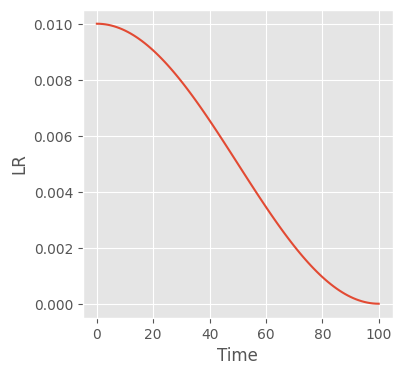

In [35]:
n_batches = 100
scheduler_f = partial(torch.optim.lr_scheduler.CosineAnnealingLR, T_max=n_batches)
train(scheduler_f, n_batches)

## Part I: Cosine Annealing

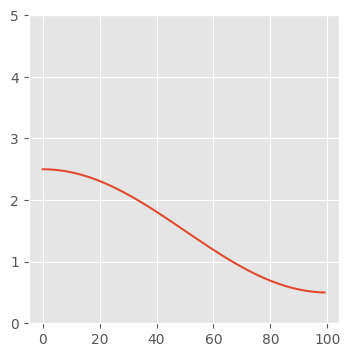

In [36]:
t_max = 100
lr_max = 2.5
lr_min = 0.5
x = torch.arange(t_max)
y = (1 + torch.cos(x * 3.141 / t_max)) / 2 * (lr_max - lr_min) + lr_min
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(x, y)
ax.set_ylim(0, 5);

In [40]:
class CosineAnnealingLRScheduler(torch.optim.lr_scheduler.LRScheduler):
    def __init__(
        self,
        optimizer,
        lr_max: float,
        lr_min: float,
        t_max: int,
        last_epoch=-1,
        verbose=False,
    ):
        # That that the superclass constructor calls .step() on the instance,
        # such that we need one additional learning rate beyond the number of
        # steps associated with each batch
        xs = torch.arange(t_max + 1).float()
        self.lrs = (1 + torch.cos(xs * 3.141 / t_max)) / 2 * (lr_max - lr_min) + lr_min
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        return [self.lrs[self._step_count - 1] for _ in self.optimizer.param_groups]

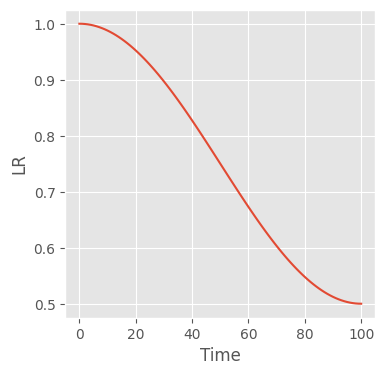

In [41]:
scheduler_f = partial(
    CosineAnnealingLRScheduler,
    lr_max=1.0,
    lr_min=0.5,
    t_max=n_batches,
)
train(scheduler_f, n_batches)

## Part II: 1 cycle 

In [56]:
t_max = 100
lr_start, lr_max, lr_end = 0.1, 0.8, 0.01

In [68]:
lra = torch.linspace(lr_start, lr_max, t_max // 2)
lrb = torch.linspace(lr_max, lr_end, t_max // 2 + t_max % 2)
lrs = torch.cat((ya, yb))

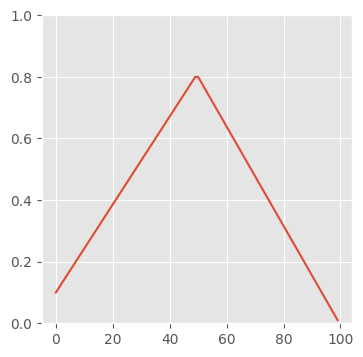

In [70]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(x, lrs)
ax.set_ylim(0, 1);

In [81]:
class OneCycleLRScheduler(torch.optim.lr_scheduler.LRScheduler):
    def __init__(
        self,
        optimizer,
        lrs,
        t_max: int,
        last_epoch=-1,
        verbose=False,
    ):
        # That that the superclass constructor calls .step() on the instance,
        # such that we need one additional learning rate beyond the number of
        # steps associated with each batch
        lr_start, lr_max, lr_end = lrs
        lra = torch.linspace(lr_start, lr_max, t_max // 2)
        lrb = torch.linspace(lr_max, lr_end, t_max // 2 + (t_max % 2) + 1)
        self.lrs = torch.cat((lra, lrb))
        print(len(self.lrs))
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        return [self.lrs[self._step_count - 1] for _ in self.optimizer.param_groups]

101


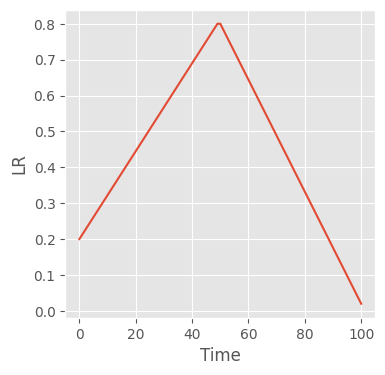

In [82]:
scheduler_f = partial(
    OneCycleLRScheduler,
    lrs=(0.2, 0.8, 0.02),
    t_max=n_batches,
)
train(scheduler_f, n_batches)